# Project : Communicate data findings on Airbnb listings in Paris

Submitted by: Melvil Lardinois

## Overview


The context is the following: I own an apartment in Paris and I would like to list it on Airbnb. I'm looking for additional information to know approximately at which price I could list the apartment and which criteria tend to be linked with good reviews. 

I used publicly available data from the Inside Airbnb website (**[http://insideairbnb.com/](http://insideairbnb.com/)**), which provides detailed information on Airbnb listings in cities around the world. 

In this analysis, I tried to answer the **following questions** :

#### 1. What type of property are available on the market ?
#### 2. Are there mainly short-term stays or long-term stays listings ?
#### 3. Visualizing the distribution of listings across Paris and identifying spatial patterns
#### 4. Checking the popularity of neighborhoods + there average price per night
#### 5. Which factors influence a listing's review score ?
#### 6. At which price should I list my apartment (compared to other similar properties) ?



First, let’s navigate our datasets.

The dataset that interests us is the *listings.csv*. It contains most of the important information such as the name, the location, the minimum number of nights you can book, the price…

There is a normal version and a “summary” version of each dataset. After investigation, it seems like the “summary” version is dropping too many important variables for our analysis, such as the number of bathrooms or the in-depth review score.

Let’s see how old is the dataset and if it's clean enough to start working with it. Later on, we will modify our dataframes based on the question we are trying to solve.

In [6]:
import urllib.request
import gzip
import shutil
import os

# URL for the data file
url = "http://data.insideairbnb.com/france/ile-de-france/paris/2023-03-13/data/listings.csv.gz"

# File name for the downloaded file
print(f'Downloading {url} ...')
filename = "listings.csv.gz"

# Download the file
urllib.request.urlretrieve(url, filename)

# Extract the file
with gzip.open(filename, 'rb') as f_in:
    with open('data/listings.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
print(f'file extracted and listings.csv created')

# Remove the .gz file
os.remove(filename)
print(f'.gz file deleted')


file extracted and listings.csv created
.gz file deleted


In [7]:
import pandas as pd

# Read the listings.csv file into a pandas DataFrame
listings_df = pd.read_csv('data/listings.csv')

# Convert the "host_since" column to a datetime object
listings_df['host_since'] = pd.to_datetime(listings_df['host_since'])

# Group the DataFrame by year and count the number of unique listings in each year
new_listings_per_year = listings_df.groupby(listings_df['host_since'].dt.year)['id'].nunique()

print("Number of new hosts per year:")
print(new_listings_per_year)

Number of new hosts per year:
host_since
2008.0        3
2009.0      102
2010.0      345
2011.0     1054
2012.0     3258
2013.0     6369
2014.0     8388
2015.0    10018
2016.0     7067
2017.0     3652
2018.0     3217
2019.0     3939
2020.0     2098
2021.0     2270
2022.0     4256
2023.0      672
Name: id, dtype: int64


In [8]:
import pandas as pd

# Read the listings.csv file into a pandas DataFrame
listings_df = pd.read_csv('data/listings.csv')

# Check for duplicates in the "id" column
duplicates = listings_df.duplicated(subset=['id'])

print(f"There are {duplicates.sum()} duplicates in the 'id' column.")

There are 0 duplicates in the 'id' column.


**So the dataset ranges from 2008 to 2023 and there are no duplicate listings. Nice !**

> ### 1. What type of property are available on the market ?



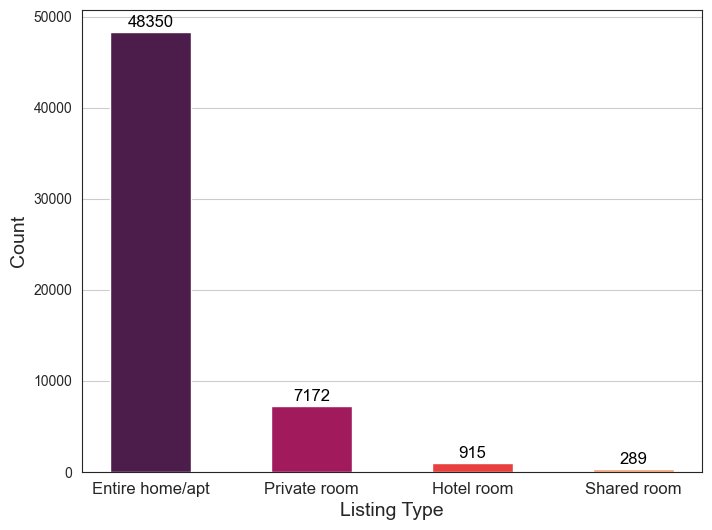

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the listings.csv file into a pandas DataFrame
listings_df = pd.read_csv('data/listings.csv')

# Get the count of each listing type
listing_counts = listings_df['room_type'].value_counts()

# Set seaborn style
sns.set_style("white")

# Generate a color palette using Seaborn
palette = sns.color_palette("rocket", len(listing_counts))

# Create a bar chart of the listing counts with a color palette
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(listing_counts.index, listing_counts.values, width=0.5, color=palette)

# add value labels
for i, v in enumerate(listing_counts.values):
    ax.text(i, v+600, str(v), color='black', ha="center", fontsize=12)

# Set chart title and axis labels
ax.set_xlabel('Listing Type', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# Set the x-tick positions to be fixed
ax.set_xticks(range(len(listing_counts.index)))

# Set the x-tick labels to be more readable
ax.set_xticklabels(listing_counts.index, rotation=0, fontsize=12)

# Add a horizontal grid to the plot
ax.yaxis.grid(True)

# Display the plot
plt.show()

**Hosts are mostly listing entire homes or apartments.**

> ### 2. Are there mainly short-term stays or long-term stays listings ?

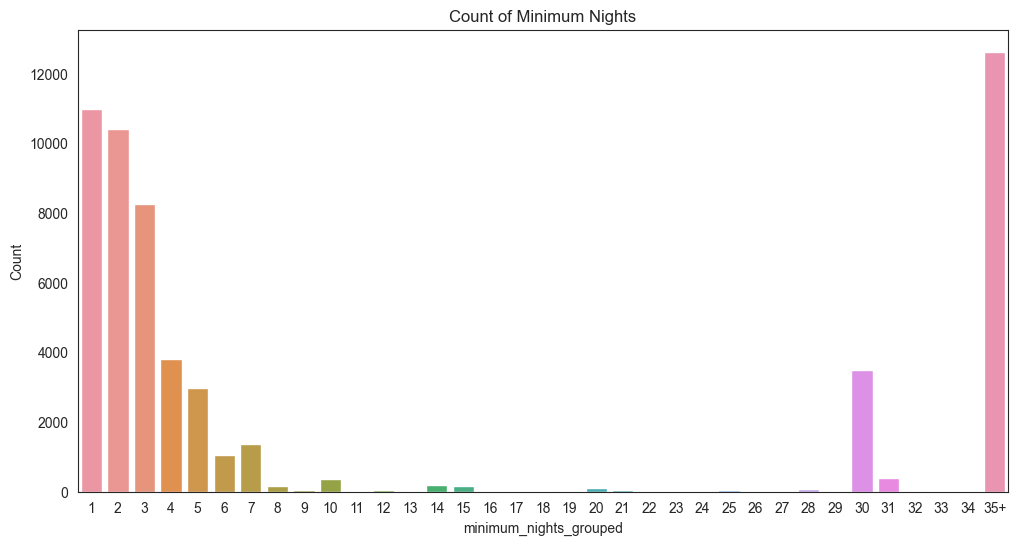

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

listings = pd.read_csv("data/listings.csv")

def group_minimum_nights(x):
    if x <= 35:
        return x
    else:
        return "35+"

listings["minimum_nights_grouped"] = listings["minimum_nights"].apply(group_minimum_nights)

order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, "35+"]

plt.figure(figsize=(12,6))
sns.countplot(data=listings, x="minimum_nights_grouped", order=order)
plt.ylabel("Count")
plt.title("Count of Minimum Nights")
plt.show()

In [11]:
# Calculate the total number of listings
total_listings = len(listings)

# Calculate the number of short term rentals (any minimum nights of 29 days or less)
short_term_listings = len(listings[listings["minimum_nights"] <= 29])

# Calculate the number of long term rentals (minimum nights of 30 or more)
long_term_listings = len(listings[listings["minimum_nights"] >= 30])

# Calculate the percentage of short term rentals and long term rentals
short_term_percentage = round((short_term_listings / total_listings) * 100, 2)
long_term_percentage = round((long_term_listings / total_listings) * 100, 2)

print(f"Percentage of short term rentals: {short_term_percentage}%")
print(f"Percentage of long term rentals: {long_term_percentage}%")

Percentage of short term rentals: 70.88%
Percentage of long term rentals: 29.12%


**We can distinguish two big categories here: listings for tourism (1 to 7 nights minimum stay) and long term rental listings (30+ days minimum stay).**
    
**70% of them are short term rentals while 30% are long term rentals.**

> ### 3. Visualizing the distribution of listings across Paris and identifying spatial patterns

In [29]:
import folium
import pandas as pd
from folium.plugins import HeatMap

# Load your listing data
listings = pd.read_csv("data/listings.csv")

# Create a map centered on Paris
paris_map = folium.Map(location=[48.864716, 2.349014], zoom_start=13, width='65%', height='65%')

# Create a HeatMap layer from the listings dataframe with lower opacity
heatmap_data = [[row['latitude'], row['longitude']] for index, row in listings.iterrows()]
HeatMap(heatmap_data, min_opacity=0.1).add_to(paris_map)

# Display the map
paris_map

I imported a shapefile of Paris' districts from https://www.data.gouv.fr/en/datasets/arrondissements-1/. There were some issues with the encoding of the column name, which are fixed at the beginning of the next cell.

Then I merged the data of the listings' locations with the district name of the shapefile to be able to display a choropleth map with the number of listings in each district.

In [13]:
import geopandas as gpd
import folium

# Read the shapefile
districts = gpd.read_file("data/arrondissements.shp")

# Replace the problematic text
districts['l_aroff'] = districts['l_aroff'].str.replace('Ã©', 'é')
districts['l_aroff'] = districts['l_aroff'].str.replace('Ã´', 'ô')
districts['l_aroff'] = districts['l_aroff'].str.replace('Ã\x89', 'É')

# Group the listings by district and count the number of listings in each district
listings_by_district = listings.groupby('neighbourhood_cleansed').size().reset_index(name='num_listings')

# Join the listings data with the districts shapefile
districts = districts.merge(listings_by_district, left_on='l_aroff', right_on='neighbourhood_cleansed')

# Create a map centered on Paris
paris_map = folium.Map(location=[48.864716, 2.349014], zoom_start=13, width='65%', height='65%')

# Create a choropleth map with the number of listings in each district
folium.Choropleth(
    geo_data=districts,
    name='choropleth',
    data=districts,
    columns=['l_aroff', 'num_listings'],
    key_on='feature.properties.l_aroff',
    fill_color='PuRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of listings'
).add_to(paris_map)

# Add a layer control to the map
folium.LayerControl().add_to(paris_map)

# Display the map
paris_map

**We can see that there is a strong concentration of listings in the north part of the city and close to the touristy areas (Montmarte, Le Marais, Quartier Latin, Tour Eiffel, Arc de Triomphe).**

**On the other hand, there are less listings in the south part (which is a bit far from everything) and in the center, around the Seine river because there are mostly museums and offices.**


> ### 4. Checking the popularity of neighborhoods + there average price per night

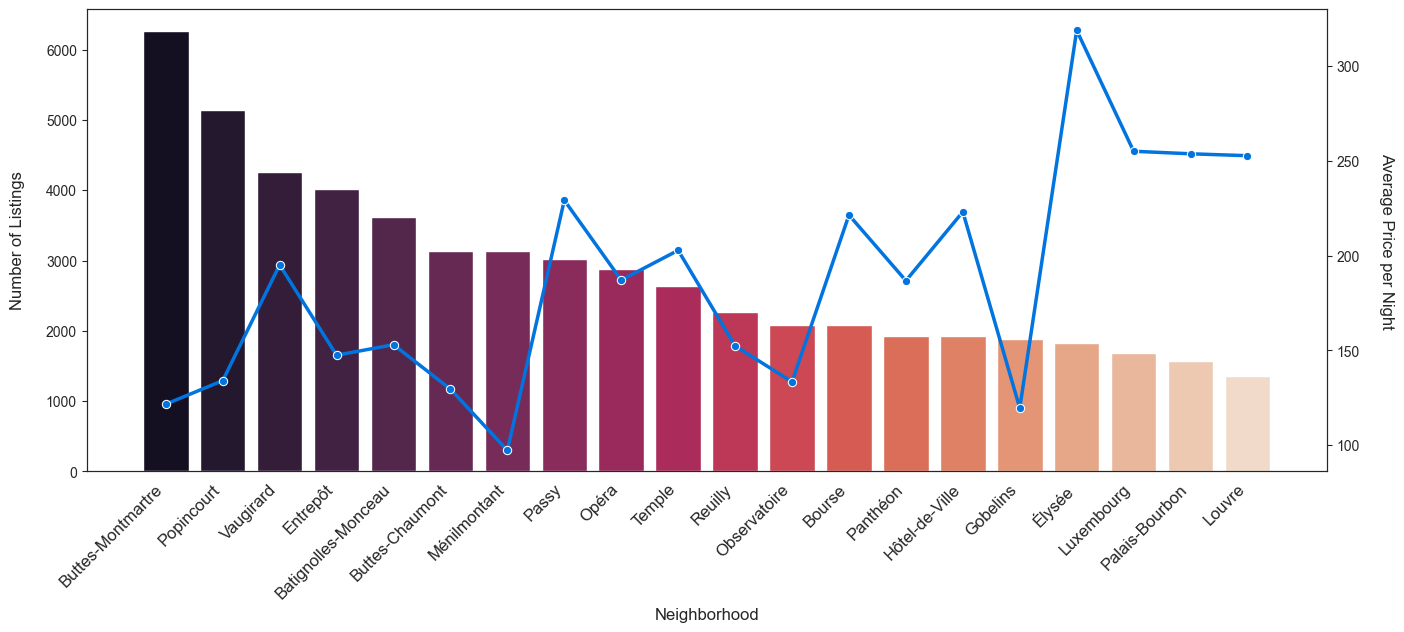

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

listings = pd.read_csv("data/listings.csv")

# Remove dollar symbol and convert price to float
listings['price'] = listings['price'].str.replace('$','').str.replace(',','').astype(float)

neighborhood_counts = listings.groupby('neighbourhood_cleansed')['id'].count().reset_index(name='count')
neighborhood_counts = neighborhood_counts.sort_values('count', ascending=False)
plt.figure(figsize=(16,6))
sns.set_style("white")
ax = sns.barplot(data=neighborhood_counts, x='neighbourhood_cleansed', y='count', order=neighborhood_counts['neighbourhood_cleansed'], palette="rocket")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
plt.xlabel("Neighborhood", fontsize=12)
plt.ylabel("Number of Listings", fontsize=12, labelpad=15)

# Create a twin axis for the average price
grouped_listings = listings.groupby('neighbourhood_cleansed')['price'].mean().reset_index(name='price')
grouped_listings = pd.merge(grouped_listings, neighborhood_counts, on='neighbourhood_cleansed').sort_values('count', ascending=False)
ax2 = ax.twinx()
sns.lineplot(data=grouped_listings, x='neighbourhood_cleansed', y='price', ax=ax2, color='#0174DF', linewidth=2.5, marker='o')
ax2.set_ylabel('Average Price per Night', fontsize=12, rotation=270)
ax2.yaxis.labelpad = 25

plt.show()

**The listings in Buttes-Montmartre have a pretty competitive price, probably because it is where you find most of the available Airbnb.**

**Otherwise, the good locations are all above 200€ per night.**

> ### 5. Which factors influence a listing's review score ?

After some research on the internet, I found that these factors could affect a listing's review score and number of bookings:

**Location**: Listings in popular neighborhoods or near tourist attractions may be more likely to receive bookings and positive reviews.

**Price**: Listings that are priced competitively may be more likely to receive bookings, but excessively high or low prices may impact the review score.

**Cleanliness and upkeep**: Listings that are clean and well-maintained are likely to receive higher review scores.

**Communication**: Hosts who communicate clearly and promptly with guests may receive higher review scores.

**Accuracy of the listing description**: Listings that accurately represent the space and amenities may receive higher review scores.

**Amenities**: Listings with desirable amenities such as air conditioning, wifi, and free parking may be more likely to receive bookings and positive reviews.

Let's see if it translates in the data ! 

We can start by creating a scatterplot matrix or a correlation matrix to visualize the relationships between the variables and also calculate the correlation coefficients to measure the strength and direction of the relationships.

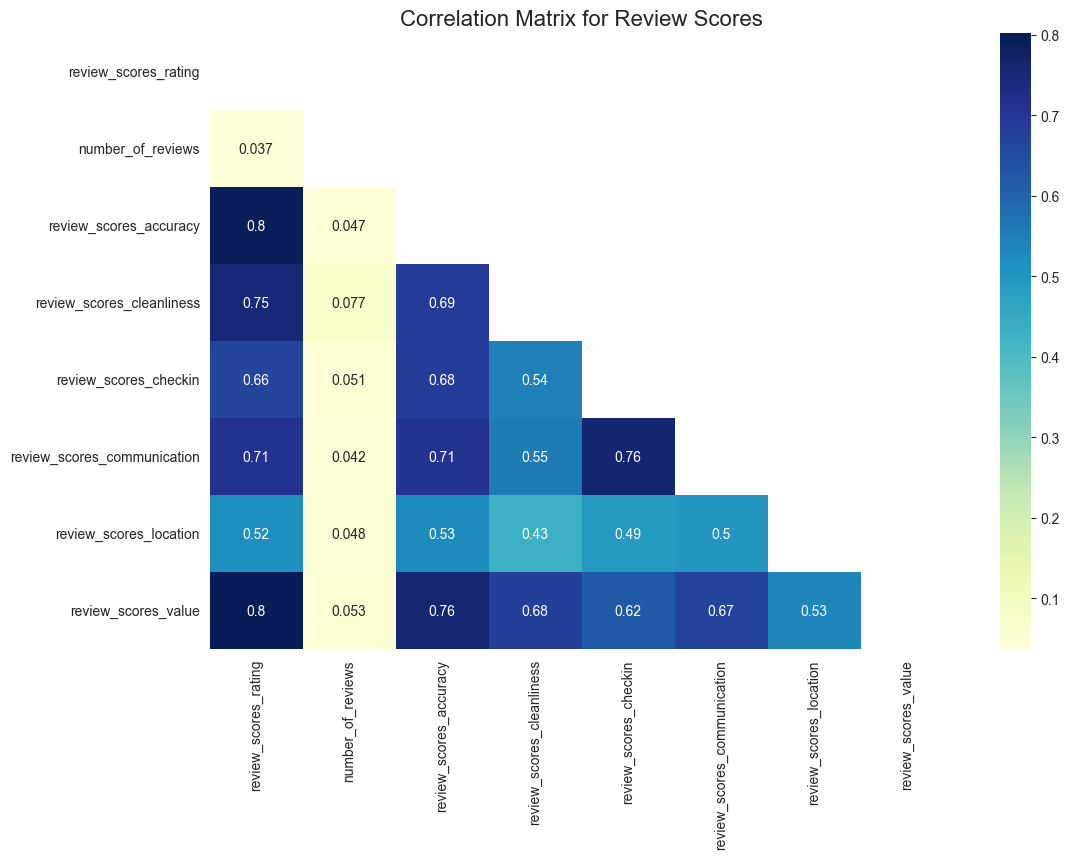

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

listings = pd.read_csv("data/listings.csv")

# select relevant columns
cols = ['review_scores_rating', 'number_of_reviews', 'review_scores_accuracy', 
        'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
        'review_scores_location', 'review_scores_value']

# drop rows with missing values
df = listings[cols].dropna()

# calculate correlation coefficients
corr = df.corr()

# plot heatmap of correlation coefficients
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap="YlGnBu")
plt.title("Correlation Matrix for Review Scores", fontsize=16)
plt.show()


**It looks like people will most likely give a good rating if the description of the listing was accurate and if they feel like they paid the right amount of money for their stay at the apartment. The cleanliness seems to really matter as well.**

**There is a strong correlation between communication score and check-in score, which probably means that as long as people are able to check-in properly, they will give a good communication score.**

> ### 6. At which price should I list my apartment (compared to other similar properties) ?

My apartment is located in the Opera neighborhood. It has 3 bedrooms, 4 beds and 2 bathrooms.

Let's make a new dataframe with these parameters and check out other listings with similar configurations.

In [48]:
listings = pd.read_csv("data/listings.csv")

# Remove dollar symbol and convert price to float
listings['price'] = listings['price'].str.replace('$','').str.replace(',','').astype(float)

# Select the listings that meet the conditions
opera_listings = listings.loc[
    (listings['neighbourhood_cleansed'] == 'Opéra') &
    (listings['room_type'] == 'Entire home/apt') &
    (listings['bedrooms'] == 3) &
    (listings['bathrooms_text'] == '2 baths')
]

# Preview the new dataframe
pd.set_option('display.max_columns', None)
opera_listings.head()
#opera_listings.info()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
832,890426,https://www.airbnb.com/rooms/890426,20230313171257,2023-03-14,city scrape,Sunny calm authentic flat,Our apartment is an haven in Paris and we live...,NaN,https://a0.muscache.com/pictures/18193438/77ac...,304318,https://www.airbnb.com/users/show/304318,Jean-Christophe,2010-11-29,"Paris, France",I like travelling and discover the world with ...,within a day,100%,92%,f,https://a0.muscache.com/im/users/304318/profil...,https://a0.muscache.com/im/users/304318/profil...,Pigalle - Saint-Georges,1.0,1.0,"['email', 'phone']",t,t,NaN,Opéra,NaN,48.88206,2.33232,Entire rental unit,Entire home/apt,6,NaN,2 baths,3.0,3.0,"[""Bed linens"", ""Heating"", ""Siemens stainless s...",280.0,6,60,6.0,6.0,60.0,60.0,6.0,60.0,NaN,t,0,0,0,6,2023-03-14,35,7,1,2013-07-14,2023-02-24,4.91,4.97,4.89,4.89,4.94,4.83,4.91,7510900344286,f,1,1,0,0,0.30
1162,1216286,https://www.airbnb.com/rooms/1216286,20230313171257,2023-03-14,city scrape,Apartment 100 m2 3 bedrooms Paris O,"The apartment is fully equipped (towels, bed l...",near many cinemas theaters museums and departm...,https://a0.muscache.com/pictures/19233330/5d5b...,6637355,https://www.airbnb.com/users/show/6637355,Dalila,2013-05-29,"Paris, France",J'a ime voyager d ou location de mon appartement,within a day,50%,50%,f,https://a0.muscache.com/im/users/6637355/profi...,https://a0.muscache.com/im/users/6637355/profi...,Pigalle - Saint-Georges,1.0,1.0,"['email', 'phone']",t,f,"Paris, Île-de-France, France",Opéra,NaN,48.87319,2.33218,Entire rental unit,Entire home/apt,4,NaN,2 baths,3.0,3.0,"[""Bed linens"", ""Heating"", ""Host greets you"", ""...",300.0,7,1125,7.0,7.0,1125.0,1125.0,7.0,1125.0,NaN,t,0,0,0,194,2023-03-14,15,2,0,2014-04-27,2022-08-26,4.93,4.93,4.86,4.93,4.93,4.93,4.64,7510905264265,f,1,1,0,0,0.14
1895,2091821,https://www.airbnb.com/rooms/2091821,20230313171257,2023-03-14,city scrape,"ROOFTOP ""Le perchoir du 2éme""","ROOFTOP ""Le Perchoir"" A 70m² duplex in the he...",The apartment is located in the heart of Paris...,https://a0.muscache.com/pictures/103804522/dd2...,10674511,https://www.airbnb.com/users/show/10674511,Pascal,2013-12-17,"Paris, France","Bonjour à tous,\r\n\r\nNous sommes une famille...",within an hour,100%,97%,f,https://a0.muscache.com/im/users/10674511/prof...,https://a0.muscache.com/im/users/10674511/prof...,II Arrondissement,1.0,5.0,"['email', 'phone', 'work_email']",t,t,"Paris, Île-de-France, France",Opéra,NaN,48.87240,2.34000,Entire loft,Entire home/apt,8,NaN,2 baths,3.0,4.0,"[""First aid kit"", ""Pets allowed"", ""Bed linens""...",396.0,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,3,6,10,195,2023-03-14,261,56,2,2015-07-04,2023-02-22,4.53,4.59,4.31,4.73,4.69,4.89,4.4

In [49]:
# Calculate average price per night for listings with minimum nights of 364 or less
price_short_stay = opera_listings.loc[opera_listings['minimum_nights'] <= 364, 'price'].mean()

# Calculate average price per night for listings with minimum nights of 365 or more
price_long_stay = opera_listings.loc[opera_listings['minimum_nights'] >= 365, 'price'].mean()

print("Average price per night for short stays:", price_short_stay)
print("Average price per night for long stays:", price_long_stay)


Average price per night for short stays: 418.4107142857143
Average price per night for long stays: 194.58333333333334


Since there are only 68 records, I can go over the statistics quickly. What we are looking for can be analyzed in the table above directly.

I can also read the listings' descriptions to check their m² and available amenities. The average price per night for short stays at 418€ seems high to me. It's probably inflated because there are much bigger apartments with similar configuration.

**If I'm going for a yearly rental, I should probably list it around 200€ per night. While if it's a day per day rental, the price should be around 320€ per night.**